# Kaggle Competition - Histopathologic Cancer Detection

In [133]:
#General libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os

#deep learning/CNN libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, Hinge
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


%matplotlib inline

### Introduction

Github link: https://github.com/desoura/CNN_Cancer_Detection

<b>Histopathology</b> is the diagnosis and study of the diseases of tissues. In this project, colour images extracted from histopathological scans from lymph nodes will be used. In short, to visualize different components of the tissue under a microscope, sections are dyed with one (or more) stains. Stains reveal cellular components, with counter-stains being used to provide contrast in the images. [Hematoxylin stains cell nuclei blue, whereas Eosin stains cytoplasm and connective tissue pink](https://pmc.ncbi.nlm.nih.gov/articles/PMC2910932/). With this basic biochemical background in mind, trained experts read or interpet scans to attempt to assess the presence of cancer in patients. 

The goal of this report is to, in lieu of a trained professional, identify metastatic cancer from histopathology scans. This will be attempted using Convolutional Neural Networks (CNNs), which are a type of neural network that can be used for image classification tasks. Through a process called **convolution**, hierarchical feature representations from input data will be learned. By using a learnable filter, across the input, feature maps can be created to highlight specific patterns (such as edges, textures, or shapes - or in our case, tumors). These feature maps are then moved through subsequent convolutional and pooling layers, gradually extracting more complex and abstract features. The fully connected layers can be used for numerous tasks, such as classification. 

This is a binary image classification task, where the classes are "cancerous" and "not cancerous", as it pertains to the histopathologic images. This will be evaluated using the area under an ROC curve, which is a measure that considers the false positive rate and the false negative rate. 

### Exploratory Data Analysis

To start, some basic exploratory data analysis will be done to explore the structure and size of the data and potential missing values.
Of note, the data input structure is a folder of .tif images for train and test purposes. The train data has an associated dataframe containing the target values for a given unique identifier (the filename).

In [16]:
#Read in data

## Training labels
df_train = pd.read_csv("train_labels.csv")

df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [17]:
df_train['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

The training data has just over 220000 entries, split between 0 (benign/not cancerous) and 1 (malignant/cancerous).

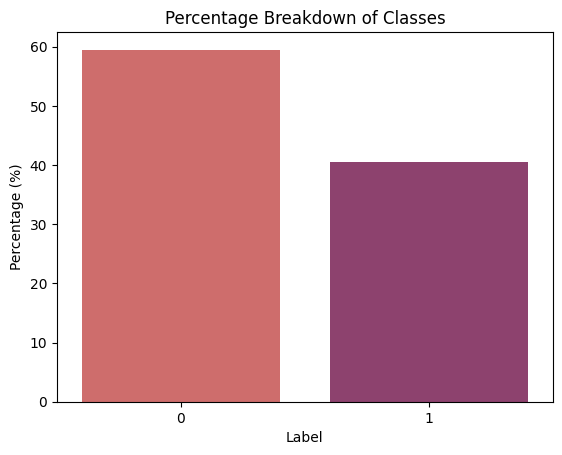

In [18]:
sns.countplot(df_train, 
              x = "label",
              stat = 'percent',
              hue = 'label',
              palette = 'flare',
              legend = False
              ).set(
                  title = 'Percentage Breakdown of Classes'
              )

plt.xlabel("Label")
plt.ylabel("Percentage (%)")
plt.show()

We can see that the training data has an approximate 60/40 split between our classes (Cancer/Not Cancer). This should not raise any major concerns in terms of model building and analysis. The proportion of classes is relatively similar. Additionally, it is expected that there would be more benign samples than malignant ones when testing for cancer. 

In [19]:
print(len(df_train))

220025


In [20]:
df_train['location'] = 'train/' + df_train['id'] + '.tif'
df_train.head()

,id,label,location
0,f38a6374c348f90b587e046aac6079959adf3835,0,train/f38a6374c348f90b587e046aac6079959adf3835...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,train/c18f2d887b7ae4f6742ee445113fa1aef383ed77...
2,755db6279dae599ebb4d39a9123cce439965282d,0,train/755db6279dae599ebb4d39a9123cce439965282d...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,train/068aba587a4950175d04c680d38943fd488d6a9d...


To get an idea of what the data we're working with looks like, we can visualize a sample of the histopathological scans. 

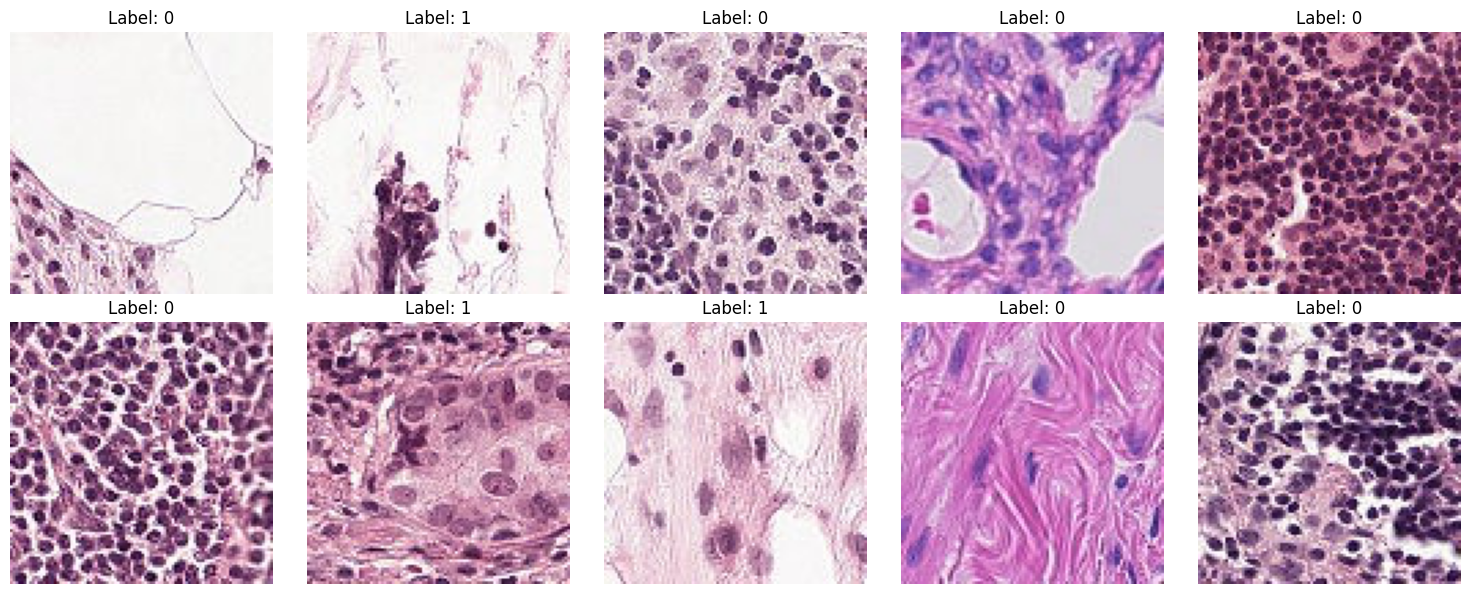

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

for i, ax in enumerate(axes.flat):
    img = mpimg.imread(df_train['location'].iloc[i]) #load each image
    ax.imshow(img)
    ax.axis('off') #don't want to see axes
    ax.set_title(f"Label: {df_train.loc[i, 'label']}")

plt.tight_layout() #adjust padding
plt.show()

In [22]:
#Missing values check
print(df_train.isnull().sum()) #no missing values!

id          0
label       0
location    0
dtype: int64


There are no missing values! Now that some exploratory data visualization has been conducted, we can proceed with some further analysis before model building.

In [23]:
#Ensure there are no duplicates
duplicates = df_train.duplicated(subset=['id']).sum()
print(f'Duplicates:\n{duplicates}')

Duplicates:
0


### Model Building and Training

Convolutional neural networks (CNNs) will be the framework and approach taken to making predictions for the cancer data. CNNs will be generated through through an Image Data Generator technique that employs the keras and tensorflow packages. This will be done using a number of convolutional layers, and potentially batch normalization and dropout depending on the model. 

Some other approaches, such as DenseNet, ResNet, and EfficientNet could be used as CNN architectures. However, these were not used due to their increased resource requirements. 

The goal of this approach is to create a model that will accurately capture the unique features of the image scans. In the initial model, an architecture with two convolutional layers and some associated pooling and dense layers will be created to attempt to capture the structure of the images. For model optimization, some hyperparameter tuning will be done in a later step to improve performance. 

In [24]:
#set seed for random components
random.seed(42)

In [25]:
#usually, strings are required for CNN architecture, so we will change the output to strings. 
df_train["label"] = df_train["label"].astype(str)  # Convert to string

In [ ]:
#split data for validation steps
train_labels, val_labels = train_test_split(df_train,
                                            test_size = 0.2,
                                            random_state = 0)

In [ ]:
#building the model
# outline the config and pooling layers
layer_config = [Conv2D(32, (3,3), 
                       activation='relu', #activation type
                       input_shape=(96, 96, 3)), #input shape of images
          MaxPooling2D(2,2),
          
          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D(2,2),
          
          Flatten(),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')]

cnn_model = Sequential(layer_config)

In [40]:
# Compilation of the model
learning_rate = 0.0001 #use a small learning rate
opt = keras.optimizers.Adam(learning_rate = learning_rate)
cnn_model.compile(optimizer = opt,
              loss = 'binary_crossentropy', #loss metric of choice
              metrics = ['accuracy'])

# Summary
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

The model summary shows the types of layers to be used as well as the parameters used and output shape determined in each step. 

In [41]:
train_dir = 'train' #set training directory


In [47]:
#create filenames for train and val labels
# Create a new 'filename' column by adding '.tif' extension
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

In [48]:
train_labels

,id,label,location,filename
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1,train/a42ed368dfea7e31fcde574fc9ab5ec921642cd4...,a42ed368dfea7e31fcde574fc9ab5ec921642cd4.tif
18438,54946370aec5fe50c6c8595e880f58051445b007,1,train/54946370aec5fe50c6c8595e880f58051445b007...,54946370aec5fe50c6c8595e880f58051445b007.tif
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1,train/a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf...,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf.tif
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0,train/09afaac18518e435c68fc1b635690c79b52d1a0e...,09afaac18518e435c68fc1b635690c79b52d1a0e.tif
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1,train/8ab7670b07494ca3b51b570fc243467a7a45895c...,8ab7670b07494ca3b51b570fc243467a7a45895c.tif
...,...,...,...,...
176963,44ba771656e7599964766cdcd439cdb1be4e4191,0,train/44ba771656e7599964766cdcd439cdb1be4e4191...,44ba771656e7599964766cdcd439cdb1be4e4191.tif
117952,c17297f6be709183c32f01d68f339cb227cd75a7,1,train/c17297f6be709183c32f01d68f339cb227cd75a7...,c17297f6be709183c32f01d68f339cb227cd75a7.tif
173685,f13383c34ffdecde4de353b912b8158a079895e7,1,train/f13383c34ffdecde4de353b912b8158a079895e7...,f13383c34ffdecde4de353b912b8158a079895e7.tif
43567,b4fcf2f281499152024ab8096270ff3b18514bba,0,train/b4fcf2f281499152024ab8096270ff3b18514bba...,b4fcf2f281499152024ab8096270ff3b18514bba.tif


In [ ]:
# Data Generators - to be input into the model. 
train_datagen = ImageDataGenerator( #set parameters
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Train data
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename', #locate training data 
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

# Validation data
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='filename', #locate validation data
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
#to avoid the overuse of resources and/or potentially overshooting the optimal values, early stopping will be employed. 
early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor 
        patience=2,         # Number of epochs with no improvement after which training will be stopped
        mode='min',          # 'min' for metrics to minimize (like loss)
        verbose=1,           
        restore_best_weights=True # Restore model weights from the epoch with the best monitored value
)

In [ ]:
#generate a model 
history = cnn_model.fit(train_gen,
                    epochs = 10,
                    validation_data = val_gen,
                    callbacks = [early_stopping])
history

Now that the model has been generated, we can see how the initial model performed on overall. Accuracy generally improved over the training process. However, there is still room for improvement, which can be done by tuning some hyperparameters. 

In [53]:
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

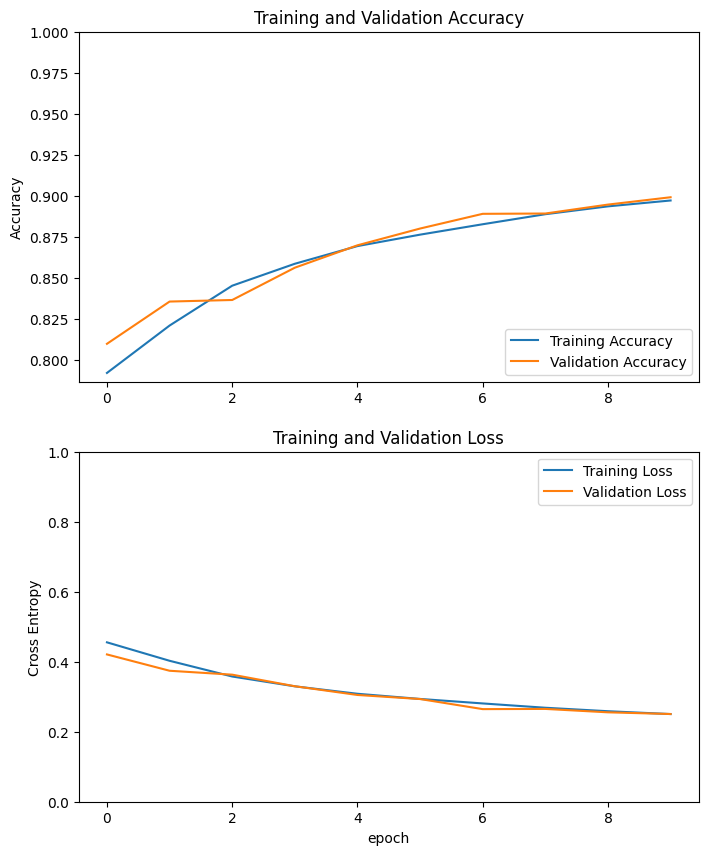

In [54]:
learning_curve(history)


In terms of updating the model, a couple of things will be done. Four convolutional layers will be used, alongside a new kernel initializer. Additionally, it seemed like the model still had potential to reach an optimal solution with only 10 epochs, so the number of epochs will be increased (with the caveat that early stopping will be employed to prevent overshooting the optimal values).

In [ ]:
config_updated = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3), kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'), #add an additional layer
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'), #add an additional layer
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Flatten(),
            # fully connect with dropout
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')]

model_updated = Sequential(config_updated)

# Compile
learning_rate = 0.0001 
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model_updated.compile(optimizer = opt,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# Summary
model_updated.summary()

The new architecture is more complex - it will potentially lead to better results. 

In [ ]:
# Model fitting
history_updated = model_updated.fit(train_gen,
                        epochs = 25,
                        validation_data = val_gen,
                        callbacks = [early_stopping])

history_updated

### Results and Analysis

The final model performs better than the initial model in terms of accuracy for training and validation. Early stopping chose the weights of the 9th epoch, which had an accuracy of 0.9326 and a validation accuracy of 0.9370. The accuracy and loss of the model over the epochs has been presented below. 

In terms of hyperparameters, the following represent key values that contributed toward performance:
* Learning rate: 0.0001 - this value lead to ideal results and prevented overfitting
* Number of epochs: 25 (however, early stopping selected the model at the 9th epoch)
* Loss: binary cross entropy
* Evaluative metric: accuracy - this is debatable, but this allows us to rule out cases in which there is no cancer detected. 
* Activation - relu

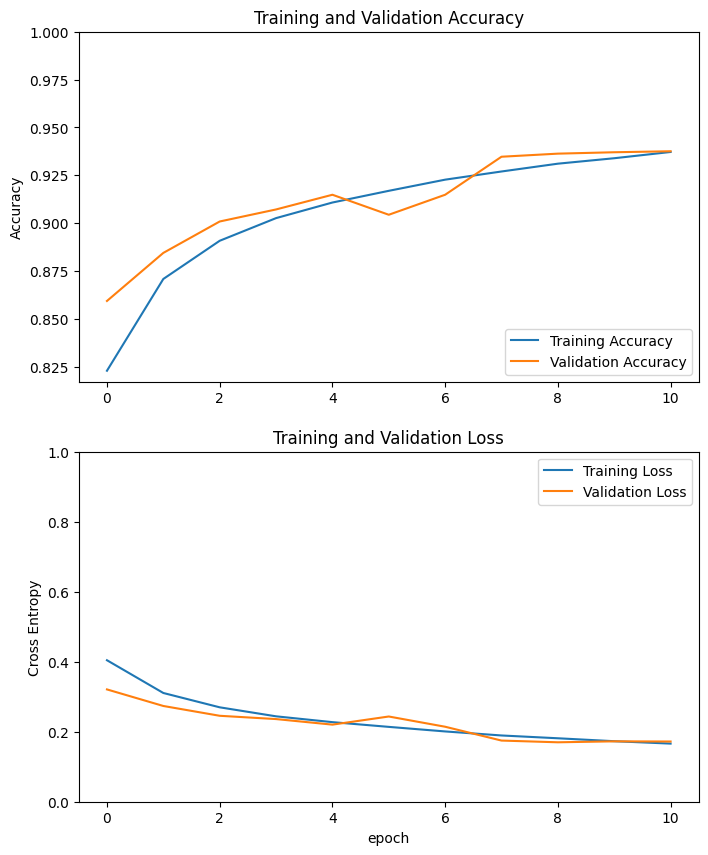

In [57]:
learning_curve(history_updated)


In [124]:
# Prepare confirmation data generator
eval_datagen = ImageDataGenerator(rescale=1./255)

eval_gen = eval_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 176020 validated image filenames.


In [ ]:
#make predictions
eval_gen.reset()
eval_predictions = model_updated.predict(eval_gen, steps=eval_gen.samples)

In [127]:
y_pred = (eval_predictions > 0.5).astype(int).reshape(-1) #change probabiliities into binary outputs
y_pred

array([0, 1, 1, ..., 1, 0, 0])

In [128]:
y_true = train_labels['label'].astype(int)
y_true

205571    1
18438     1
47235     1
42780     0
70202     1
         ..
176963    0
117952    1
173685    1
43567     0
199340    0
Name: label, Length: 176020, dtype: int64

In [130]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    104765
           1       0.94      0.93      0.93     71255

    accuracy                           0.95    176020
   macro avg       0.94      0.94      0.94    176020
weighted avg       0.95      0.95      0.95    176020



In [131]:
cm = confusion_matrix(y_true, y_pred)
cm_pct = cm/cm.sum(axis = 1).reshape(-1,1)
cm

array([[100587,   4178],
       [  5342,  65913]])

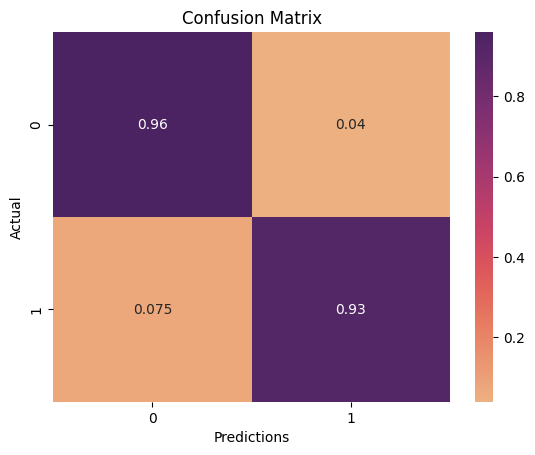

In [132]:
sns.heatmap(cm_pct, annot=True, 
            cmap='flare', 
            xticklabels=[0,1], 
            yticklabels=[0,1])
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

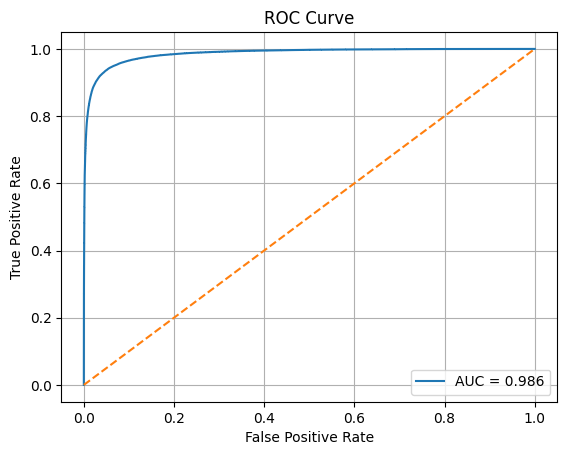

In [134]:
fpr, tpr, thresholds = roc_curve(y_true, eval_predictions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

The confusion matrix above presents a summary of model performance across classes. The overall performance of the model on the training data can also be seen by the ROC curve above. 

In terms of performance, the CNN architecture performed well for this classification task. There may still be room for improvement, which will be further discussed below. CNNS appear to be an adequate tool for classifying images, particularly those with abstract shapes. This is due to the sliding kernel approach which allows for the feature extraction of various types of shapes and forms. 

In [ ]:
test_dir = 'test/' #set test directory for test data

In [74]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 57458 validated image filenames.


In [ ]:
#make predictions with final model
test_gen.reset()
predictions = model_updated.predict(test_gen, steps=test_gen.samples)

# Prepare the submission DataFrame
filenames = test_gen.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_final = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_final.to_csv('cancer_detection_submission.csv', index=False)

After submission to Kaggle, the public score achieved was 0.8599 and the private score achieved was 0.8313.

### Conclusion


Evaluating the model on the training data resulted in a AUC score of **0.986**, an overall accuracy of **0.93**, and an overall f1 score of **0.94**. In terms of evaluation on the test data, submission to Kaggle resulted in a public score of **0.8599** and a private score of **0.8313**, in which the evaluation metric was an AUC score on a ROC curve. 

This challenge has revealed that deep learning can provide an adequate solution to classifying cancer scans as malignant or benign. This approach was done using Convolutional Neural Networks (CNNs), which seem to be an appropriate tool for image analysis and classification.  This has a very direct application and implications for hospitals and medical professions, either as a supplement to clinical expertise or a substitute for it. There is a possibility that these types of architectures can be expanded to use in other types of medical applications, such as x-rays and magnetic resonance imaging techniques. 

Importantly, while this approach did see moderate success, there is potential for improvement in further iterations or tasks. The use of imaging preprocessing libraries could be explored to see if some initial filtering could be applied to the scans. The use of other libraries and approaches, such as DenseNet, ResNet, and EfficientNet could be used to see if there could be model improvements. However, one consideration for these approaches is efficiency; while there is certainly room for improvement, the balance between efficiency and effectiveness might be of interest. These approaches were considered for the challenge initially, but were not used due to lack of resources. 

A mixed model approach might be of interest for the future. Combining image data with other patient information, such as clinical data, vital signs, medical history, and other pertinent information could be useful if said information was available. 

Notably, the current model performed slightly better with classification of true positives than true negatives. This brings up a matter of priorities for classification. In this case, true positives refer to benign cases predicted to be benign, and true negative cases refer to malignant cases being predicted to be malignant. A future improvement might be to make changes to evaluation metrics to favour true negative cases. This is a question of priority and depends on the user, but it may be of interest to be "overcorrective" for malignant cases than to let a case of cancer be misdiagnosed. 

In conclusion, Convolutional Neural Networks provide an effective framework for detecting cancerous tissue and provides an avenue for further research in this field. 

### Resources

https://pmc.ncbi.nlm.nih.gov/articles/PMC2910932/

https://github.com/basveeling/pcam